In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import compute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [182]:
from IPython.display import display, HTML

In [183]:
df = pd.read_csv('../data/transfertLearning/train.csv')
df['sales'] = df['sales'].round().astype(int)
df = df[df['sales'] > 0]

In [184]:
df['date'] = pd.to_datetime(df['date'])


In [185]:
# df['day'] = df['date'].dt.day
# df['month'] = df['date'].dt.month
# df['year'] = df['date'].dt.year

In [186]:
def create_store_family_lag_features(df, target_col='sales', lag_days=14, 
                                   date_col='date', store_col='store_nbr', 
                                   family_col='family'):
    df_lag = df.copy()
    
    # Convert date column to datetime
    df_lag[date_col] = pd.to_datetime(df_lag[date_col])
    
    # Sort by store, family, and date
    df_lag = df_lag.sort_values([store_col, family_col, date_col])
    
    # Create lag features for each store-family combination
    lag_features = []
    
    for lag in range(1, lag_days + 1):
        df_lag[f'{target_col}_lag_{lag}'] = df_lag.groupby([store_col, family_col])[target_col].shift(lag)
    
    # Rolling statistics untuk setiap store-family
    for window in [3, 7, 14]:
        if window <= lag_days:
            df_lag[f'{target_col}_rolling_mean_{window}'] = (
                df_lag.groupby([store_col, family_col])[target_col]
                .rolling(window=window, min_periods=1)
                .mean()
                .shift(1)
                .reset_index(level=[0,1], drop=True)
            )
            df_lag[f'{target_col}_rolling_std_{window}'] = (
                df_lag.groupby([store_col, family_col])[target_col]
                .rolling(window=window, min_periods=1)
                .std()
                .shift(1)
                .reset_index(level=[0,1], drop=True)
            )
            df_lag[f'{target_col}_rolling_min_{window}'] = (
                df_lag.groupby([store_col, family_col])[target_col]
                .rolling(window=window, min_periods=1)
                .min()
                .shift(1)
                .reset_index(level=[0,1], drop=True)
            )
            df_lag[f'{target_col}_rolling_max_{window}'] = (
                df_lag.groupby([store_col, family_col])[target_col]
                .rolling(window=window, min_periods=1)
                .max()
                .shift(1)
                .reset_index(level=[0,1], drop=True)
            )
    
    # Trend features untuk setiap store-family
    df_lag[f'{target_col}_diff_1'] = df_lag.groupby([store_col, family_col])[target_col].diff(1)
    df_lag[f'{target_col}_diff_7'] = df_lag.groupby([store_col, family_col])[target_col].diff(7)
    
    # Seasonal features
    df_lag['day_of_week'] = df_lag[date_col].dt.dayofweek
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df_lag['quarter'] = df_lag[date_col].dt.quarter
    df_lag['is_weekend'] = (df_lag[date_col].dt.dayofweek >= 5).astype(int)
    df_lag['week_of_year'] = df_lag[date_col].dt.isocalendar().week
    
    # Reset index
    df_lag = df_lag.reset_index(drop=True)
    
    return df_lag

In [187]:
df_lag = create_store_family_lag_features(df, lag_days=14) 

In [188]:
df_lag = df_lag.dropna()
df_lag.head()

,id,date,store_nbr,family,sales,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,...,sales_rolling_mean_14,sales_rolling_std_14,sales_rolling_min_14,sales_rolling_max_14,sales_diff_1,sales_diff_7,day_of_week,quarter,is_weekend,week_of_year
14,28512,2013-01-17,1,AUTOMOTIVE,1,0,1.0,1.0,2.0,2.0,...,2.285714,0.994490,1.0,5.0,0.0,-1.0,3,1,0,3
15,32076,2013-01-19,1,AUTOMOTIVE,5,0,1.0,1.0,1.0,2.0,...,2.214286,1.050902,1.0,5.0,4.0,2.0,5,1,1,3
16,33858,2013-01-20,1,AUTOMOTIVE,3,0,5.0,1.0,1.0,1.0,...,2.357143,1.277446,1.0,5.0,-2.0,1.0,6,1,1,3
17,35640,2013-01-21,1,AUTOMOTIVE,1,0,3.0,5.0,1.0,1.0,...,2.357143,1.277446,1.0,5.0,-2.0,-1.0,0,1,0,4
18,37422,2013-01-22,1,AUTOMOTIVE,1,0,1.0,3.0,5.0,1.0,...,2.071429,1.071612,1.0,5.0,0.0,-1.0,1,1,0,4


In [ ]:
target = 'sales'
drop_cols = ['id', 'date']
features = [col for col in df_lag.columns if col not in drop_cols + [target]]

X = df_lag[features]
y = df_lag[target]

categorical_cols = ['store_nbr', 'family']
numerical_cols = [col for col in features if col not in categorical_cols]


# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Apply transformations
X_processed = preprocessor.fit_transform(X)

import joblib
joblib.dump(preprocessor, 'encoder.joblib')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

categorical_cols = ['store_nbr', 'family']
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomizedSearchCV(xgb, param_distributions, n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1, random_state=42))
])

model.fit(X_train, y_train)

best_model = model.named_steps['regressor'].best_estimator_
predictions = model.predict(X_test)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, shuffle=False)
# # model = load_model("transfert_learning_model_checkpoint.h5")  
# model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
# model.fit(X_train, y_train)
# # model = XGBRegressor()

# # model.load_model("xgb1.h5")   
# model.save_model("xgb1.h5")
# predictions = model.predict(X_test)

In [193]:
predictions

array([6.3239644e+03, 9.8407686e+03, 1.0684633e+04, ..., 2.0096412e+00,
       3.2983921e+00, 2.6803958e+00], dtype=float32)

In [194]:
# Calculate performance metrics
rmse = mean_squared_error(y_test,predictions)
mae = mean_absolute_error(y_test,predictions)

rmse, corr, mae, rae, rrse, mape, r2 = compute_error(
    np.ravel(y_test), 
    np.ravel(predictions)
)


print("RMSE:", rmse)
print("Corrélation:", corr)
print("MAE:", mae)
print("RAE:", rae)
print("RRSE:", rrse)
print("MAPE:", mape)
print("R2:", r2)
print("----------------------------------")

RMSE: 298.1008544635153
Corrélation: 0.9889889781375959
MAE: 46.092687689634346
RAE: 0.042438962617283575
RRSE: 0.1499568520833627
MAPE: 15.889732728949795
R2: 0.9775129425132485
----------------------------------


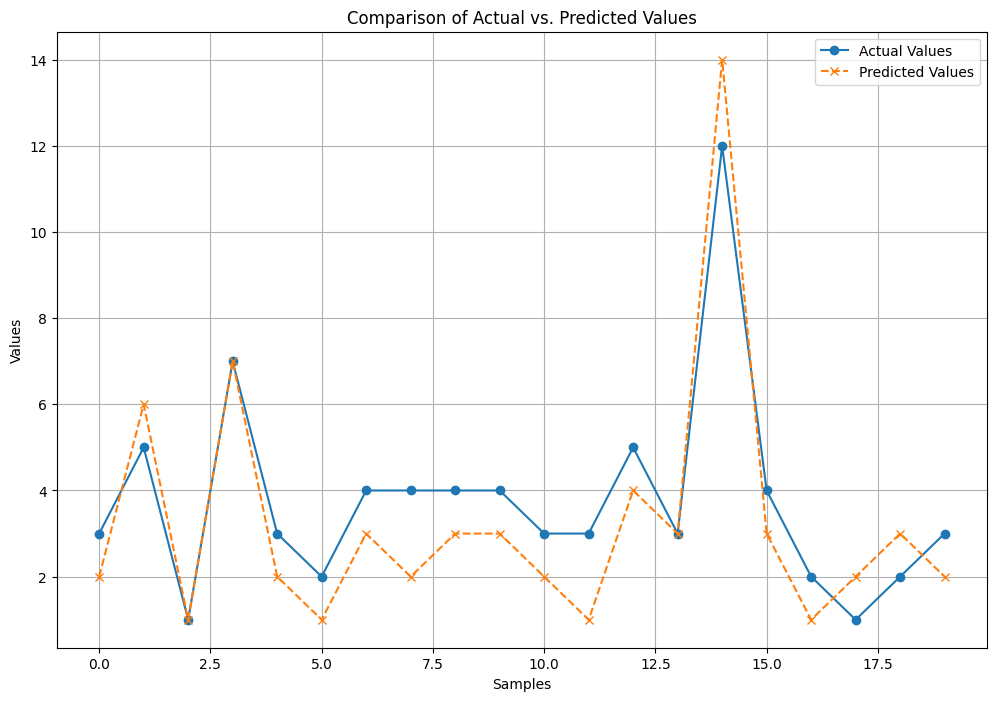

In [195]:
plt.figure(figsize=(12, 8))
pred_int = predictions.reshape(predictions.shape[0])[-20:].astype(int)

plt.plot(range(len(y_test[-20:])), y_test[-20:], label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(pred_int)), pred_int, label='Predicted Values', marker='x', linestyle='--')

plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of Actual vs. Predicted Values')

# plot legend
plt.legend()

# Activate the grid
plt.grid(True)

# Save image in high resolution (300 DPI)
# plt.savefig('comparison_plot.png', dpi=300)

# plot graph
plt.show()
